## Detecção de Anomalia com Deep Autoencoder Baseado no Erro de Reconstrução

**Criado por: Leonardo Franco de Godói**


**Data: 18/09/2019**

--------------------------------------------------------------------------------------------------------------------------

#### Descrição:
O dataset utilizado, contendo dados obtidos de rolamentos, está disponível em Case Western Reserve University bearing data center, através do link: 

http://csegroups.case.edu/bearingdatacenter/pages/welcome-case-western-reserve-university-bearing-data-center-website.

O dataset contempla três tipos de falhas mecânicas, associadas a:

- Elementos rolantes.
- Anel interno.
- Anel externo.

Além disso, o dataset é também dividido entre duas condições de operação em termos de velocidade de rotação - configuração de carga:

- 20-0
- 30-2

Os dados foram obtidos através de 8 sensores:

- 1 (vibração do motor).
- 2, 3, 4 (vibração da caixa de engrenagens planetária nas direções X, Y e Z).
- 5 (torque do motor).
- 6, 7, 8 (vibração da caixa de engrenagens paralela nas direções X, Y e Z).

Para esta implementação, foi adotado o subconjunto contendo os dados relativos à falhas no anel externo na configuração 30-2. 

Um Deep Autoencoder (Deep AE) com a configuração (12-6-3-6-12) é aplicado para aprender as features do subconjunto de dados
saudáveis. A anomalia é então detectada através da reconstrução de um dataset contendo dados de falhas, para os quais os valores de MAE (Mean Absolute Error) são maiores.

---------------------------------------------------------------------------------------------------------------------------

*Importando os pacotes necessários.*

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow import set_random_seed
from sklearn import preprocessing
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

*Definindo o diretório dos datasets originais.*

In [4]:
dir_health = 'health_30_2.csv'
dir_fault = 'outer_30_2.csv'

*Definindo os parâmetros da rede neural.*

In [5]:
hidden_layer1 = 12
hidden_layer2 = 6
hidden_layer3 = 3
NUM_EPOCHS = 100
BATCH_SIZE = 1000
act_func = 'selu'

*Carregando so datasets originais.*

- *Dataset saudável: 8 sensores x 1048560 medições.*

- *Dataset com falha no anel externo: 8 sensores x 1048560 medições.*

In [6]:
dataset_health = pd.read_csv(dir_health, sep='\t', header=-1)
dataset_fault = pd.read_csv(dir_fault, sep='\t', header=-1)

*Estruturando dois novos datasets.*

- *Dataset de treinamento: 8 sensores x 600000 medições (todas saudáveis).*

- *Dataset de validação: 8 sensores x 600000 (falha a partir da medição 300000).*

In [7]:
dataset_train = dataset_health[:600000]
dataset_test = dataset_fault[600001:900001]
dataset_test = dataset_test.append(dataset_fault[:300000]) 

*Removendo a última coluna (vazia).*

In [8]:
dataset_train = dataset_train.iloc[:, :-1]
dataset_test = dataset_test.iloc[:, :-1]

*Definindo rótulos para as colunas e ajustando as linhas.*

In [9]:
dataset_train.columns = ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4',
                          'Sensor 5', 'Sensor 6', 'Sensor 7', 'Sensor 8']
dataset_test.columns = dataset_train.columns
dataset_test.index = dataset_train.index

*Criando novos datasets com dados normalizados (0 a 1).*

In [10]:
scaler = preprocessing.MinMaxScaler()
data_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
data_test = pd.DataFrame(scaler.fit_transform(dataset_test), 
                              columns=dataset_test.columns, 
                              index=dataset_test.index)

*Definindo a semente (seed) aleatoriamente.*

In [11]:
seed(10)
set_random_seed(10)

*Definindo o modelo do Deep Autoencoder.*

In [12]:
model = Sequential()
model.add(Dense(hidden_layer1, activation=act_func, 
                input_shape=(data_train.shape[1],)))
model.add(Dense(hidden_layer2, activation=act_func))
model.add(Dense(hidden_layer3, activation=act_func))
model.add(Dense(hidden_layer2, activation=act_func))
model.add(Dense(hidden_layer1, activation=act_func))
model.add(Dense(data_train.shape[1]))

Instructions for updating:
Colocations handled automatically by placer.


*Mostrando a estrutura do modelo.*

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 24        
_________________________________________________________________
dense_5 (Dense)              (None, 12)                84        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 104       
Total params: 419
Trainable params: 419
Non-trainable params: 0
_________________________________________________________________


*Compilando o modelo para treinamento.*

- *Otimizador: Adam (Adaptive Moment Estimation).*

- *Função de perda: MSE (Mean Square Error).*    

In [15]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

*Criando o mecanismo de early Stopping para evitar overfitting.*

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

*Treinando o modelo.*

- *5% dos dados são reservados para validação durante o treinamento.*

- *É declarado um callback para ativar o Early Stopping assim que for observado que a função parou de "descer".*

In [18]:
history_train = model.fit(np.array(data_train), np.array(data_train),
                   batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS,
                   validation_split=0.05,
                   callbacks=[es],
                   verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 570000 samples, validate on 30000 samples
Epoch 1/100
570000/570000 [==============================] - 3s 5us/step - loss: 0.0426 - acc: 0.6779 - val_loss: 0.0015 - val_acc: 0.9713
Epoch 2/100
570000/570000 [==============================] - 2s 4us/step - loss: 0.0023 - acc: 0.9030 - val_loss: 0.0011 - val_acc: 0.9956
Epoch 3/100
570000/570000 [==============================] - 2s 3us/step - loss: 0.0017 - acc: 0.9123 - val_loss: 7.7942e-04 - val_acc: 0.9934
Epoch 4/100
570000/570000 [==============================] - 2s 3us/step - loss: 0.0013 - acc: 0.9257 - val_loss: 6.2431e-04 - val_acc: 0.9848
Epoch 5/100
570000/570000 [==============================] - 2s 3us/step - loss: 0.0011 - acc: 0.9245 - val_loss: 5.5487e-04 - val_acc: 0.9851
Epoch 6/100
570000/570000 [==============================] - 2s 4us/step - loss: 9.1010e-04 - acc: 0.9286 - val_loss: 5.2282e-04 - val_acc: 0.9922
Epoch 7/100
570000/570000 [====================

*Gerando predições a partir dos dados de treinamento.*

In [19]:
pred_train = model.predict(np.array(data_train))
pred_train = pd.DataFrame(pred_train, columns=data_train.columns)
pred_train.index = data_train.index

*Calculando o MAE das predições sobre os dados de treinamento.*

*Média móvel com janela de 10000 amostras é usada para suavizar a curvas.*

In [21]:
scored_train = pd.DataFrame(index=data_train.index)
scored_train['Loss MAE'] = np.mean(np.abs(pred_train-data_train), axis = 1)
scored_train = scored_train.rolling(window=10000).mean()

*Gerando predições a partir dos dados de validação.*

In [22]:
pred_test = model.predict(np.array(data_test))
pred_test = pd.DataFrame(pred_test, columns=data_test.columns)
pred_test.index = data_test.index

*Calculando o MAE das predições sobre os dados de validação.*

*Média móvel com janela de 10000 amostras é usada para suavizar a curvas.*

In [23]:
scored_test = pd.DataFrame(index=data_test.index)
scored_test['Loss MAE'] = np.mean(np.abs(pred_test-data_train), axis = 1)
scored_test = scored_test.rolling(window=10000).mean()

*Plotando o desempenho em função do MAE.*

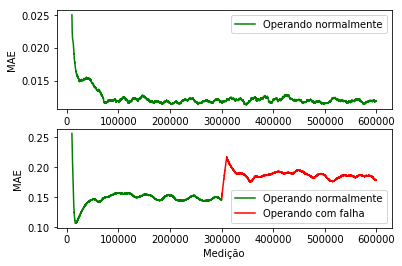

In [26]:
plt.figure(1)
plt.subplot(211)
plt.plot(scored_train, label='Operando normalmente', color='green')
plt.xlabel('Medição')
plt.ylabel('MAE')
plt.legend()
plt.subplot(212)
plt.plot(scored_test[:300000], label='Operando normalmente', color='green')
plt.plot(scored_test[300001:600000], 
         label='Operando com falha', color='red')
plt.xlabel('Medição')
plt.ylabel('MAE')
plt.legend()